In [1]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [2]:
"""
Created on November 2 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2


#import statments
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from __future__ import division

import DELCgen
# this is the package that actually generates the SFR histories
from DELCgen import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 24})
%config InlineBackend.rc = {}
%matplotlib inline

# Example of TDE in a galaxy and AGN in a galaxy - not finished

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [22]:
# amplitude
A=1
#slope on the short time scales
a_low=0.1
#slope on the longer time scales 
a_high=2
# intercept/offset: adds constant to the final output; not used it this work
c=0



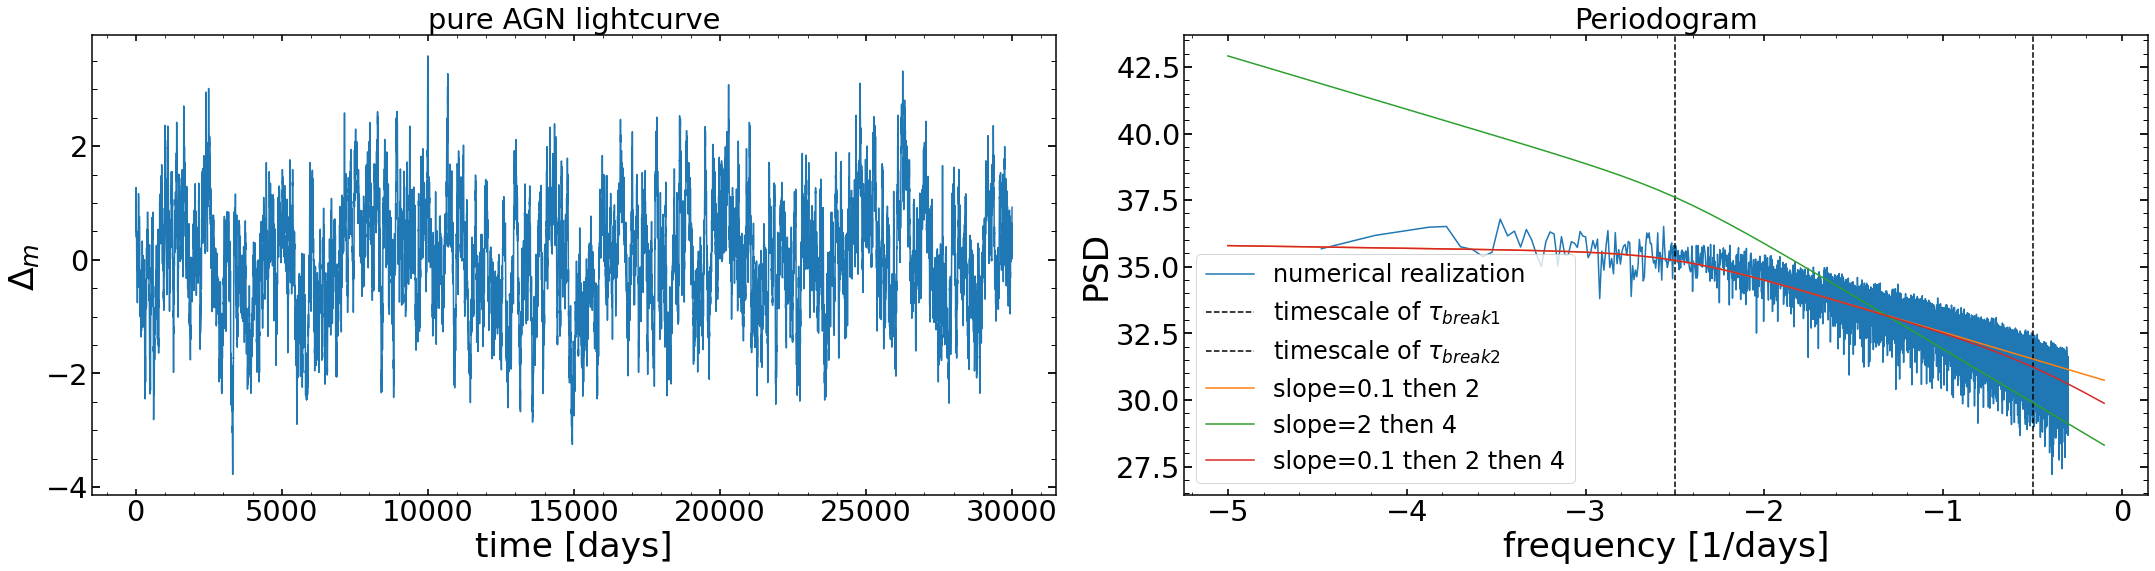

In [41]:
v_bend_1=1.0/(10**2.5)
v_bend_2=1.0/(10**0.5)

delc_2_3 =Simulate_TK_Lightcurve(Bending2PL, (A,v_bend_1,v_bend_2,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=30000,randomSeed=1234)

v_bend_1_index=list(np.arange(-5,+0,0.1)).index(find_nearest(np.arange(-5,+0,0.1),np.log10(v_bend_1)))
v_bend_2_index=list(np.arange(-5,+0,0.1)).index(find_nearest(np.arange(-5,+0,0.1),np.log10(v_bend_2)))

v_bend_1_delc_index=list(np.log10(delc_2_3.freq)).index(find_nearest(np.log10(delc_2_3.freq),np.log10(v_bend_1)))
v_bend_2_delc_index=list(np.log10(delc_2_3.freq)).index(find_nearest(np.log10(delc_2_3.freq),np.log10(v_bend_2)))

PSD_2=[]
PSD_4=[]
PSD_2_4=[]
for v in 10**(np.arange(-5,+0,0.1)):
    PSD_2.append(BendingPL(v,A,v_bend_1,a_low,a_high,c))
    PSD_4.append(BendingPL(v,A,v_bend_1,a_high,a_high+2,c))
    PSD_2_4.append(Bending2PL(v,A,v_bend_1,v_bend_2,a_low,a_high,c))

#############################################
# Plot showing created movement around Main Sequence, the periodogram, the structure function and the ACF
# shown for the example with tau_{break} = 100, i.e., example 2
plt.figure(figsize=(30,8))
plt.subplot(121)
plt.plot(delc_2_3.flux)
plt.title('pure AGN lightcurve')
plt.xlabel('time [days]')
plt.ylabel('$\\Delta_{m}$ ')

plt.subplot(122)
plt.plot(np.log10(delc_2_3.periodogram[0]),np.log10(delc_2_3.periodogram[1]),label='numerical realization')
#plt.plot(np.log10(frequency),np.log10(explicit2)+np.log10(delc_flux_2_3.periodogram[1])[0]-np.log10(explicit2)[0],lw=5,label='analytical form')
plt.axvline(np.log10(v_bend_1),ls='--',color='black',label='timescale of $\\tau_{break1}$')
plt.axvline(np.log10(v_bend_2),ls='--',color='black',label='timescale of $\\tau_{break2}$')
plt.title('Periodogram')
plt.xlabel('frequency [1/days]')
plt.ylabel('PSD')

plt.plot(np.arange(-5,+0,0.1),np.log10(PSD_2)-np.log10(PSD_2)[v_bend_1_index]+np.log10(delc_2_3.periodogram[1])[v_bend_1_delc_index], label='slope='+str(a_low)+' then '+str(a_high),)
plt.plot(np.arange(-5,+0,0.1),np.log10(PSD_4)-np.log10(PSD_4)[v_bend_2_index]+np.log10(delc_2_3.periodogram[1])[v_bend_2_delc_index], label='slope='+str(a_high)+' then '+str(a_high+2))
plt.plot(np.arange(-5,0,0.1),np.log10(PSD_2_4)-np.log10(PSD_2_4)[v_bend_1_index]+np.log10(delc_2_3.periodogram[1])[v_bend_1_delc_index], label='slope='+str(a_low)+' then '+str(a_high)+' then '+str(a_high+2))

plt.legend()



plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [37]:
# magnitude of AGN at time 1: m1
# magnitude of AGN at time 2: m2
# magnitude of galaxy: mg

# adding flux of galaxy and AGN given their magnitudes

# Flux 1 as a function of flux of galaxy
# F1=Fg*(10**(0.4*(mg-m1)))

# Flux 2 as a function of flux of galaxy
# F2=Fg*(10**(0.4*(mg-m2)))

# Observed flux 1
# F_obs1=F1+Fg = Fg * [ 1 + 10**(0.4*(mg-m1)) ]

# Observed flux 2
# F_obs2=F2+Fg = Fg * [ 1 + 10**(0.4*(mg-m2)) ]

# difference between observed flux 2 and observed flux 1 in magnitudes
# magnitude observed at time_1, magnitude of galaxy minus magnitude observed at time 1, difference between AGN magnitude 2 and magnitude 1
def calculate_m_observed_2(m_observed_1,mg_minus_m1,delta_2_1):
    return m_observed_1 + 2.5*np.log10((1+10**(0.4*(mg_minus_m1)))/(1+10**(0.4*(mg_minus_m1+delta_2_1))))


In [39]:
# when they are equal, you see some fraction of the effect 
calculate_m_observed_2(19,0,-1)

19.38872383138672

# Searching for the objects 

## importing data from ZTF 

In [11]:
import urllib
import urllib.request

In [13]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [21]:
import pandas as pd
# dataframe taking inputs from Jenny
df = pd.read_csv (r'/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/fornevan.lst',sep=' ')

df

,RA,DEC,ZGAL
0,0.2964583333333333,-10.032139,0.048900
1,0.7853333333333333,15.811722,0.117500
2,4.370166666666666,-0.307444,0.111800
3,6.621375,0.086000,0.213300
4,7.786749999999999,14.762056,0.118800
...,...,...,...
608,228.19545,17.808945,0.064875
609,250.76721,26.786280,0.086814
610,236.16783,4.975874,0.039663
611,232.75098,4.280731,0.038888


In [26]:
i=0
Ra_single_object=df['RA'].iloc[i]
Dec_single_object=str(df['DEC'].iloc[i]

In [76]:
# 613 objects in the database
len(df)

613

In [79]:
# time 55196 => 12/31/2009
# time 59214 => 12/31/2020

# using example : https://www.ztf.caltech.edu/page/dr3

for i in tqdm(range(306,len(df))):
    try:
        Ra_single_object=str(df['RA'].iloc[i])
        Dec_single_object=str(df['DEC'].iloc[i])

        url='https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE+'+Ra_single_object+'+'+Dec_single_object+'+0.0008&BANDNAME=r&NOBS_MIN=3&TIME=55196.0+59214.0&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table'

        urllib.request.urlretrieve(url,'/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/'+str(i))

        df_lightcurve = pd.read_csv (r'/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/'+str(i),skiprows=53,delim_whitespace=True)
        # remove the last column that has all 'NaN'
        df_lightcurve=df_lightcurve.iloc[:,:24]
        df_lightcurve.columns = ['oid', 'expid','hjd','mjd','mag','magerr','catflags','filtercode','ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                                'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
        df_lightcurve.to_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(i)+".pkl")
    except:
        pass


 32%|████████████▉                            | 97/307 [08:25<15:22,  4.39s/it]


 64%|█████████████████████████▍              | 195/307 [17:55<10:47,  5.78s/it]


 95%|██████████████████████████████████████▏ | 293/307 [26:47<01:07,  4.80s/it]


100%|████████████████████████████████████████| 307/307 [28:04<00:00,  5.49s/it]


## Summary of results

In [130]:

list_of_df_sum=[]
for i in tqdm(range(0,len(df))):
    try:
        df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(i)+".pkl")
        
        
        # 0. number, 1. number_of_observation, 2. first observation, 3. mean observation, 4. last observation, 
        # 5. mean diff in observations times, 6. mean magnitude, 7. mean limit mag

        
        df_sum=[i,len(df_lightcurve), np.min(df_lightcurve['mjd'].values),np.mean(df_lightcurve['mjd'].values),np.max(df_lightcurve['mjd'].values),\
        np.mean(np.diff(df_lightcurve['mjd'].values)),np.mean(df_lightcurve['mag'].values),np.mean(df_lightcurve['limitmag'].values)]
        
    except:
        df_sum=[i,-99,-99,-99,-99,-99,-99,-99]
        
    
    list_of_df_sum.append(df_sum)
    
array_of_df_sum=np.array(list_of_df_sum)

array_of_df_sum_cleaned=array_of_df_sum[array_of_df_sum[:,1]>0]

array_of_df_sum_cleaned_50=array_of_df_sum[array_of_df_sum[:,1]>50]

100%|███████████████████████████████████████| 613/613 [00:01<00:00, 537.01it/s]


In [98]:

np.min(df_lightcurve['mjd'].values),np.mean(df_lightcurve['mjd'].values),np.max(df_lightcurve['mjd'].values),\
np.mean(np.diff(df_lightcurve['mjd'].values)),np.mean(df_lightcurve['mag'].values)

(58215.2406019,
 58432.25693736944,
 58846.463287,
 2.734280060139856,
 18.253752890277777)

In [100]:
df_lightcurve

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
0,623210300008460,46124060,2.458216e+06,58215.240602,18.173870,0.037977,0,zr,174.567857,26.404670,...,10,3,20.209999,25.800343,0.037916,0.135472,0.000068,30,1.017,1
1,623210300008460,46324098,2.458218e+06,58217.240984,18.237549,0.039484,0,zr,174.567816,26.404618,...,10,3,21.110001,26.039105,0.035332,0.122917,0.000058,30,1.013,3
2,623210300008460,46325833,2.458218e+06,58217.258333,18.164982,0.037773,0,zr,174.567807,26.404635,...,10,3,21.309999,26.153334,0.036886,0.120863,0.000064,30,1.008,3
3,623210300008460,46427311,2.458219e+06,58218.273113,18.237003,0.039470,0,zr,174.567804,26.404645,...,10,3,21.379999,26.178038,0.030938,0.129656,0.000044,30,1.013,3
4,623210300008460,46427402,2.458219e+06,58218.274028,18.265526,0.040172,0,zr,174.567822,26.404648,...,10,3,21.250000,26.191574,0.029701,0.127901,0.000042,30,1.013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1668204400009823,82820256,2.458583e+06,58582.202569,18.235922,0.041278,0,zr,174.567777,26.404579,...,4,4,21.580000,26.086924,0.038103,0.119389,0.000069,30,1.069,1
140,1668204400009823,83928157,2.458594e+06,58593.281574,18.347076,0.044240,0,zr,174.567820,26.404610,...,4,4,20.680000,26.100317,0.032282,0.113383,0.000049,30,1.029,1
141,1668204400009823,84324373,2.458598e+06,58597.243738,18.316444,0.043397,0,zr,174.567802,26.404590,...,4,4,21.500000,26.122854,0.033634,0.103895,0.000054,30,1.006,1
142,1668204400009823,84825899,2.458603e+06,58602.258993,18.126314,0.038608,0,zr,174.567807,26.404652,...,4,4,20.760000,26.009300,0.036295,0.109319,0.000064,30,1.032,1


Text(0, 0.5, 'number of objects')

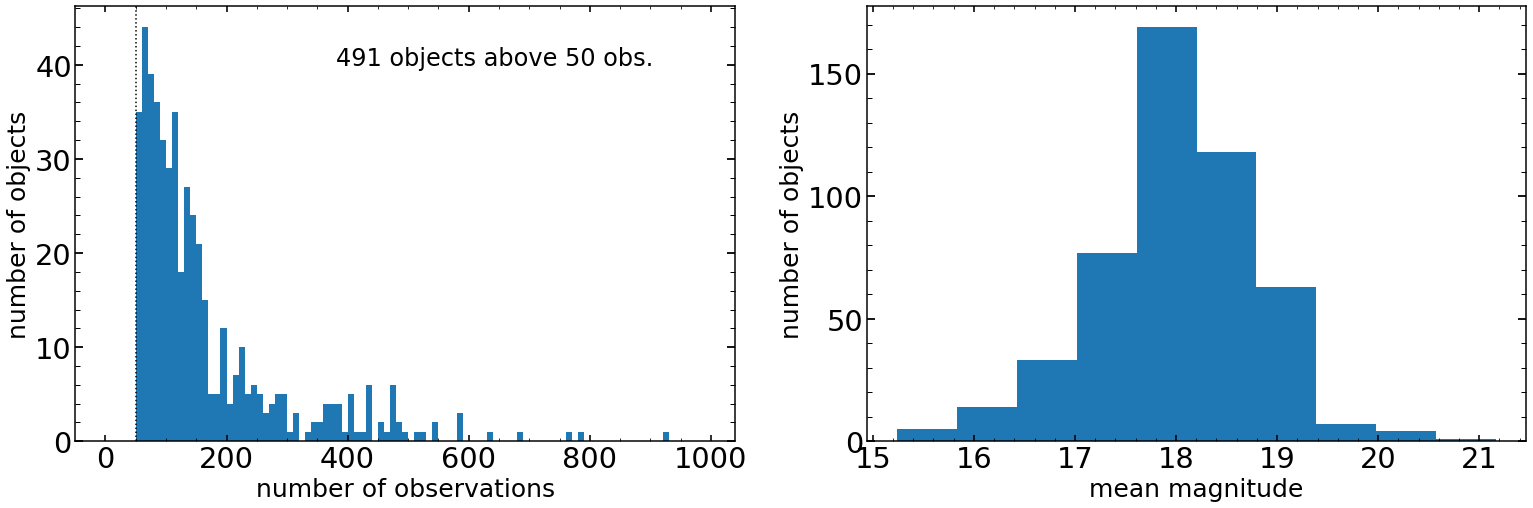

In [217]:
plt.figure(figsize=(26,8))
plt.subplot(121)
plt.hist(array_of_df_sum_cleaned_50[:,1],bins=np.arange(0,1000,10))
plt.axvline(50,color='black',ls=':')
plt.xlabel('number of observations',size=25)
plt.ylabel('number of objects',size=25)
plt.text(380,40,'491 objects above 50 obs.')

plt.subplot(122)
plt.hist(array_of_df_sum_cleaned_50[:,6])
plt.xlabel('mean magnitude',size=25)
plt.ylabel('number of objects',size=25)

(array([  1.,   5.,  32.,  90., 146., 119.,  55.,  30.,   9.,   4.]),
 array([0.05110801, 0.60755517, 1.16400234, 1.72044951, 2.27689668,
        2.83334385, 3.38979102, 3.94623819, 4.50268536, 5.05913253,
        5.6155797 ]),
 <a list of 10 Patch objects>)

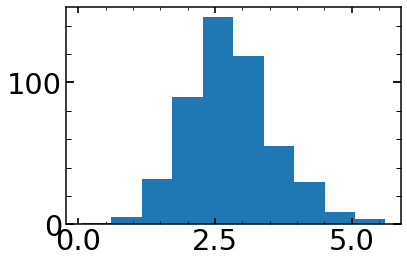

In [136]:
plt.hist(array_of_df_sum_cleaned_50[:,7]-array_of_df_sum_cleaned_50[:,6])

In [140]:
# typical AGN in the sample

# number of observations
median_len=np.median(array_of_df_sum_cleaned_50[:,1])

In [141]:
# median magnitude
median_mag=np.median(array_of_df_sum_cleaned_50[:,6])

In [155]:
array_of_df_sum_cleaned_50_median=array_of_df_sum_cleaned_50[(array_of_df_sum_cleaned_50[:,1]<(median_len+10))&(array_of_df_sum_cleaned_50[:,1]>(median_len-10))\
                           &(array_of_df_sum_cleaned_50[:,6]<median_mag+0.1)&(array_of_df_sum_cleaned_50[:,6]>(median_mag-0.1))]

In [159]:
index_50=array_of_df_sum_cleaned_50_median[:,0].astype(int)

In [160]:
df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(index_50[0])+".pkl")

Text(58600, 18.3, 'RA: 203.695 /DEC:36.3 /z:0.02690')

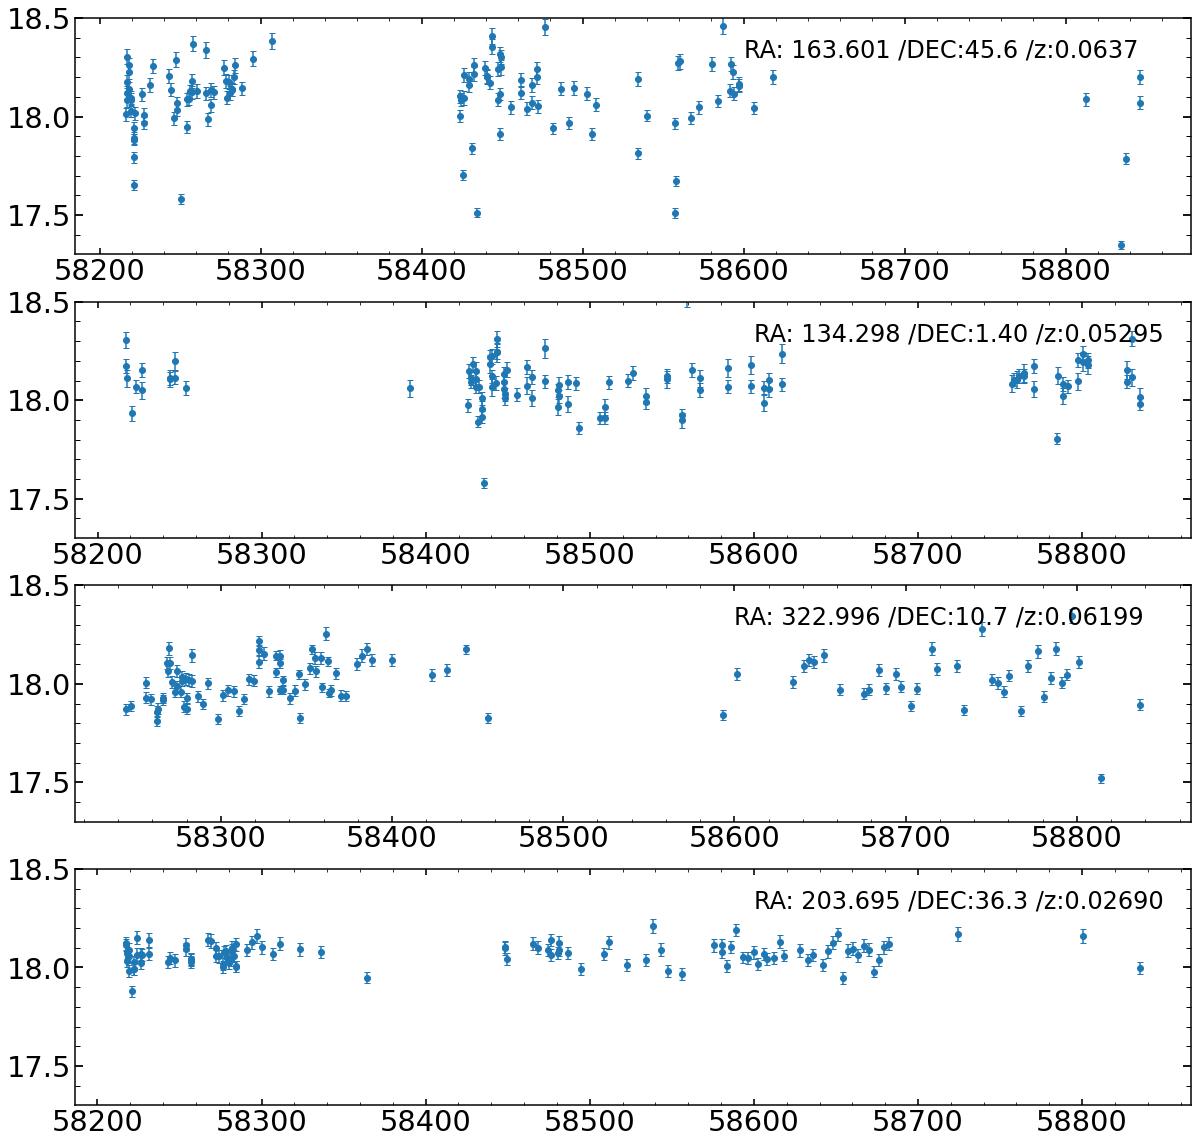

In [203]:
plt.figure(figsize=(20,20))
plt.subplot(411)
df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(index_50[0])+".pkl")
plt.errorbar(df_lightcurve['mjd'].values,df_lightcurve['mag'].values,yerr=df_lightcurve['magerr'].values,ls='',marker='o',capsize=3)
plt.ylim(17.3,18.5) 
plt.text(58600,18.3,'RA: '+str(df.iloc[index_50[0]]['RA'][:7])+' /DEC:'+str(str(df.iloc[index_50[0]]['DEC'])[:4])+' /z:'+str(df.iloc[index_50[0]]['ZGAL'])[:7])

plt.subplot(412)
df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(index_50[1])+".pkl")
plt.errorbar(df_lightcurve['mjd'].values,df_lightcurve['mag'].values,yerr=df_lightcurve['magerr'].values,ls='',marker='o',capsize=3)
plt.ylim(17.3,18.5) 
plt.text(58600,18.3,'RA: '+str(df.iloc[index_50[1]]['RA'][:7])+' /DEC:'+str(str(df.iloc[index_50[1]]['DEC'])[:4])+' /z:'+str(df.iloc[index_50[1]]['ZGAL'])[:7])


plt.subplot(413)
df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(index_50[2])+".pkl")
plt.errorbar(df_lightcurve['mjd'].values,df_lightcurve['mag'].values,yerr=df_lightcurve['magerr'].values,ls='',marker='o',capsize=3)
plt.ylim(17.3,18.5) 
plt.text(58600,18.3,'RA: '+str(df.iloc[index_50[2]]['RA'][:7])+' /DEC:'+str(str(df.iloc[index_50[2]]['DEC'])[:4])+' /z:'+str(df.iloc[index_50[2]]['ZGAL'])[:7])

plt.subplot(414)
df_lightcurve=pd.read_pickle("/Users/nevencaplar/Documents/Variability/Low_mass_Jenny/LightCurves_data/"+str(index_50[3])+".pkl")
plt.errorbar(df_lightcurve['mjd'].values,df_lightcurve['mag'].values,yerr=df_lightcurve['magerr'].values,ls='',marker='o',capsize=3)
plt.ylim(17.3,18.5)
plt.text(58600,18.3,'RA: '+str(df.iloc[index_50[3]]['RA'][:7])+' /DEC:'+str(str(df.iloc[index_50[3]]['DEC'])[:4])+' /z:'+str(df.iloc[index_50[3]]['ZGAL'])[:7])

In [194]:
str(df.iloc[index_50[0]]['DEC'])[:7]

'45.6918'